# Common Boggle Words

The primary purpose of this notebook is to find the most common valid words that appear in Boggle boards. There are about $16! \cdot 6^{16} \approx 5.9 \times 10^{25}$ different boards, not taking duplicate letters into account, such that we must recourse to sampling to estimate word probabilities.

Boggle is a game with a square board, with 16 slots for cubes. Each cube has letters on its 6 faces. At the start of each game, the board is shuffled so that each cube is in a random slot, and each cube has a random face showing.

The goal of the game is to find as many chains of showing letters as possible on the resultant board. A player's score is based on the number of words that no other player found (larger unique words get higher scores). To be precise, a word chain must be a non-repeating sequence of horizontally, vertically, or diagonally contiguous cubes. Now, the same letter may appear twice in a path, but not the same cube. The words must belong to an agreed upon dictionary, and have some minimum length.

## Simulating Boggle

Here are the 16 cubes one will find in a standard Boggle board:

In [1]:
cubes = [('m', 'u', 'qu', 'h', 'n', 'i'),
         ('n', 'g', 'e', 'e', 'a', 'a'),
         ('d', 'r', 'y', 'v', 'l', 'e'),
         ('t', 't', 'r', 'e', 'y', 'l'),
         ('o', 'a', 'b', 'b', 'o', 'j'),
         ('h', 'w', 'v', 'e', 'r', 't'),
         ('s', 's', 'o', 'i', 't', 'e'),
         ('s', 'h', 'a', 'p', 'c', 'o'),
         ('g', 'e', 'w', 'n', 'e', 'h'),
         ('u', 'm', 'c', 'o', 't', 'i'),
         ('n', 'h', 'n', 'l', 'z', 'r'),
         ('t', 'w', 'a', 'o', 't', 'o'),
         ('p', 's', 'a', 'f', 'f', 'k'),
         ('t', 's', 't', 'i', 'd', 'y'),
         ('e', 'r', 'l', 'i', 'x', 'd'),
         ('s', 'u', 'e', 'e', 'n', 'i')]

To simulate the process of shuffling a board, both the slot and face of each cube will be chosen uniformly.

In [19]:
from random import choice, shuffle
from itertools import islice

def rand_board():
    board = []
    shuffle(cubes)
    cube_order = iter(cubes)
    for i in range(4):
        row = islice(cube_order, 4)
        board.append([choice(cube) for cube in row])
    return board

In [20]:
rand_board()

[['d', 'c', 'i', 'm'],
 ['n', 'n', 'f', 't'],
 ['a', 'u', 't', 'j'],
 ['e', 'e', 'l', 'e']]

To find viable words on a board, we'll recursively traverse adjoining letters from each of the 16 cube slots. Once a sequence goes out of bounds or repeats a cube, traversal in that direction will stop. 

Now, at each step in this process we could look up the sequence in a hash table (dictionary). But, it may be the case that the current sequence is no prefix of any dictionary word. So, it will be much more efficient to store the dictionary in a trie. [Here](http://stackoverflow.com/a/11016430) is an inspiring elegant implementation.

In [21]:
def make_trie(words):
    root = {}
    for word in words:
        node = root
        for letter in word:
            node = node.setdefault(letter, {})
        node[None] = None    # signify that node is a word
    return root

In [5]:
make_trie(['apply', 'apple'])

{'a': {'p': {'p': {'l': {'e': {None: None}, 'y': {None: None}}}}}}

Now let's write a recursive function that generates unique words on a given board, of at least some length.

In [6]:
from itertools import product

def get_words(board, trie, min_len=3):
    '''Yield possible words from a given board and trie.
    '''
    offsets = [(-1, -1), (-1, 0), (-1, 1),
               (0,  -1),          (0,  1),
               (1,  -1), (1,  0), (1,  1)]
    
    def recur(i, j, path, seen, node):
        if (i, j) in seen:    # path can't cross itself
            return
        if not (0 <= i < 4) or not (0 <= j < 4):    # path can't wrap around board
            return
        letter = board[i][j]
        path += letter
        seen.add((i, j))
        if letter in node:    # path is a prefix
            if None in node[letter]:    # path is a word
                yield path
            for i_off, j_off in offsets:    # traverse neighbors even if path is word
                yield from recur(i + i_off, j + j_off, path, seen.copy(), node[letter])
    
    seen = set()
    for i, j in product(range(4), range(4)):
        for word in recur(i, j, '', set(), trie):
            if len(word) >= min_len and word not in seen:
                yield word
                seen.add(word)

Finding words necessitates a dictionary, and a Scrabble-esque dictionary seems fitting. Conveniently, the analagous Words With Friends game's dictionary is [publicly available](http://gaming.stackexchange.com/a/7163): the Enhanced North American Benchmark Lexicon. So I'm going to use that.

In [7]:
with open('enable1.txt') as f:
    trie = make_trie(word.strip() for word in f)

## Estimating Word Probabilities

To estimate word frequencies, we'll gather relative frequencies from random boards. But how many boards to sample from?

We can view the appearance of a specific word as a Bernoulli random variable with some unknown probability. We'd like to sample enough boards so that the resultant $k$ most common words is are in fact the most common, and in order.

In the land of probability bounds, where Markov and Chebyshev wander wide, one called Hoeffding's inequality is particularly powerful when it comes to Bernoulli variables. It can tell us how tight an $\epsilon$-sized confidence interval will be with $n$ samples.

Specifically, let $X_1, \ldots, X_n \sim \mathrm{Bernoulli}(p)$. Then, for any $\epsilon > 0$,

$$P(\left| \overline{X_n} - p \right| > \epsilon) \le 2 e^{-2n\epsilon^2}$$

So, to be $\alpha$ confident that some variable is within error $\epsilon$ of it's true value, we'll need

$$n \ge \frac{1}{2\epsilon^2}\log{\frac{2}{\alpha}}$$

samples.

This applies to any Bernoullie variable, and each random Boggle board gives a Bernoulli value to every word (it appears or it doesn't). So, we can just sample a bunch of boards, which will probably produce a tight enough bound.

However, we'll have to be very diligent about choosing our confidence $\alpha$, and tightness $\epsilon$. We can't guarantee that the top $k$ words are in fact the top $k$, and in order, but it does ossify those top probabilities with a diligently chosen $\epsilon$.

Experimenting with 1000 boards showed that top 10 words' probabilities overlap, suggesting that we need $\epsilon < 0.001$ to be, say, $\alpha = 0.1$ confident that the ordering is correct. Unfortunately, this would lead to $n \ge 1.5 \times 10^6$ boards, which is too many hours of computation. Instead we'll shoot for just having the same set of top words, rather than correct ranking. The difference in probability between the empirical most common word and the 20th (we choose $k$ arbitrarily) was about 0.01, yielding $n \ge 14979$ boards, which is more manageable.

In [8]:
from collections import Counter
from tabulate import tabulate

NBOARDS = 14979

counts = Counter()
for _ in range(NBOARDS):
    board = rand_board()
    counts += Counter(get_words(board, trie, min_len=4))

table = [(i, word, count/NBOARDS) for i, (word, count)
         in enumerate(counts.most_common(20), start=1)]
print(tabulate(table, headers=['Rank', 'Word', 'Frequency'], floatfmt='.4f'))

  Rank  Word      Frequency
------  ------  -----------
     1  tees         0.0645
     2  teen         0.0638
     3  tone         0.0594
     4  tent         0.0593
     5  note         0.0593
     6  toea         0.0565
     7  teat         0.0557
     8  toes         0.0555
     9  test         0.0551
    10  ates         0.0519
    11  seta         0.0519
    12  rete         0.0517
    13  seat         0.0516
    14  sent         0.0512
    15  neat         0.0505
    16  nets         0.0501
    17  nett         0.0501
    18  eats         0.0497
    19  rote         0.0495
    20  tets         0.0491


## Common and Ordinary Word Ranking

The most common list is interesting, but some of the words are so ordinary that other players will probably know them and also find them. To improve one's chances of winning Boggle, it would be nice to have a ranking that takes into account both a word's probability of occurence, *and ordinariness*.

This is reminiscent [tf-idf weighting](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html)! Our current list gives us the *term frequency*, so all that remains is to find each term's *inverse document frequency*. Here, we assume that usage corresponds to how likely it is for a word to be known.

We'll use word usage counts from [American National Corpus](http://www.anc.org/data/anc-second-release/frequency-data/). However, some of the words from Boggle might have various endings (e.g. "apple", "apples"), and those should add in frequency for "ordinariness." So we'll stem the words for lookup.

In [9]:
from nltk.stem import SnowballStemmer
from collections import defaultdict

snow = SnowballStemmer('english')
freqs = defaultdict(int)
min_freq = 1    # smallest frequency found, for use with Boggle words not in list

with open('ANC-token-count.txt', encoding='ISO-8859-1') as f:    # there's weird characters
    for word, *_, freq in map(str.split, f):
        if word == 'Total':    # there was a total count of words at the end
            continue
        word, freq = snow.stem(word), float(freq)
        freqs[word] += freq
        min_freq = freqs[word]

Now, we just need to calculate the scores of the words output a new sorted list.

In [10]:
from math import log

tfs, idfs = [], []
for word, count in counts.items():
    word = snow.stem(word)
    tfs.append(1 + log(count))
    idfs.append(log(1 + 1/freqs.get(word, min_freq)))

scores = sorted([(tf*idf, word) for tf, idf, word in zip(tfs, idfs, counts.keys())], reverse=True)
table = [(i, word, score) for i, (score, word) in enumerate(scores[:20], start=1)]
print(tabulate(table, headers=['Rank', 'Word', 'Score']))

  Rank  Word      Score
------  ------  -------
     1  toea    130.923
     2  seta    129.506
     3  nett    128.886
     4  stet    128.567
     5  tret    127.864
     6  sett    127.791
     7  eath    127.574
     8  teel    127.402
     9  haet    127.254
    10  hest    126.361
    11  thae    125.584
    12  hent    125.224
    13  sere    123.014
    14  tela    122.756
    15  teth    122.669
    16  seel    122.396
    17  erne    122.196
    18  hoer    122.129
    19  tost    121.79
    20  sone    121.233


# Epilogue

After completing this task, several sub-topics came to mind. We address some of those here. Unlike in previous sections, we will be lax proving the correct number of boards.

## Number of Possible Words Distribution

It would be interesting to see the minimum, maximum, mean, etc. of the number of words found over all boards. For the sake of brevity, rather than fitting the distribution and devising estimators, we'll just plot a simple histogram. And I choose an arbitrarily large number of boards to sample from.

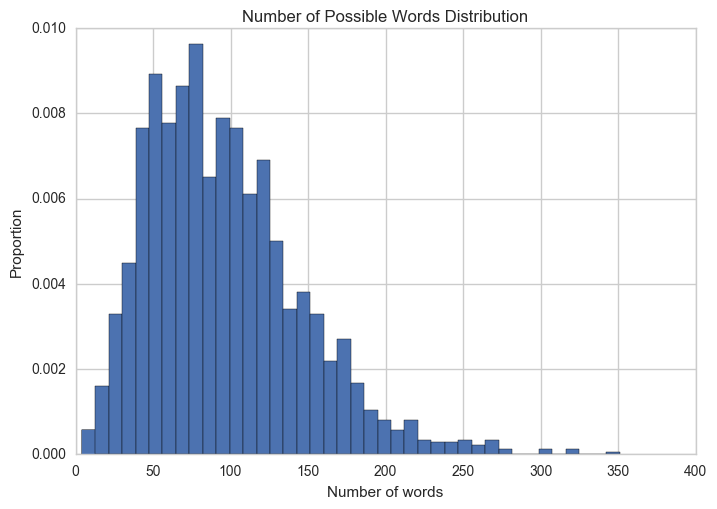

In [22]:
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline
seaborn.set_context('notebook')
seaborn.set_style('whitegrid')

num_words = []
for _ in range(2000):
    num_words.append(len(list(get_words(rand_board(), trie))))
    
plt.hist(num_words, bins=40, normed=True)
plt.title('Number of Possible Words Distribution')
plt.xlabel('Number of words')
plt.ylabel('Proportion')
plt.show()

## Best Proportion of Vowels

A friend gave the comment that the "best" Boggle boards are comprised of 40% vowels. Best, here, was intended to mean highest number of word solutions. Now to experimentally prove this claim.

In [12]:
from itertools import chain
from collections import defaultdict

NBOARDS = 1000
data = defaultdict(int)    # store how many words found per vowel, summed over boards
vowels = set('aeiou')    # for simplicity we assume that these are the only vowels

for _ in range(NBOARDS):
    num_vowels = 0
    board = rand_board()
    for letter in chain(*board):
        if letter in vowels:
            num_vowels += 1
    num_words = len(list(get_words(board, trie, min_len=4)))
    data[num_vowels] += num_words

Now to plot the mean number of found words per number of vowels:

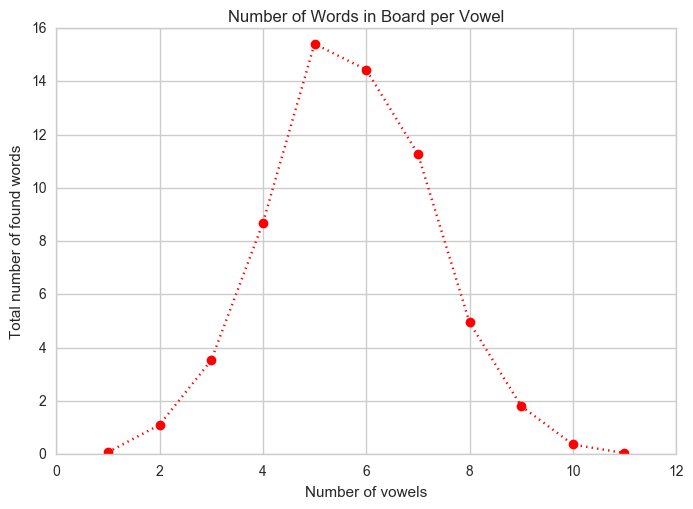

In [13]:
x, y = zip(*data.items())

plt.plot(x, [t/NBOARDS for t in y], 'ro:')
plt.title(r'Number of Words in Board per Vowel')
plt.xlabel('Number of vowels')
plt.ylabel('Total number of found words')
plt.show()

In [14]:
6/16

0.375

Would you look at that, 40% was pretty spot on for an off the cuff comment.